In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding

Different embedding scheme. The embeddings this time are learned. Because of this we have the option to pre-train the embeddings using a masked language model or something else

In [10]:
df = pd.read_csv(r"C:\python\research\experiments\datasets\TimeBasedFeatures-Dataset-15s-VPN.csv")
df = df.drop(columns=['Unnamed: 0'])
df.head()

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
0,9368711.0,16.0,4.0,1564818.0,1549373.0,190205.285714,203290.456522,389822.391917,370323.719754,10.353612,...,267600.198443,1871488.0,1.983656e+06,2195089.0,1.832197e+05,1234883.0,1420565.0,1523088.0,161096.539275,0
1,7340238.0,18.0,4.0,1567554.0,1527893.0,165686.977273,186914.846154,317267.548742,304370.651301,11.580006,...,221462.862028,1491627.0,3.572433e+06,5653239.0,2.942704e+06,1131498.0,1324636.0,1517774.0,273138.379008,0
2,4644225.0,29.0,15.0,1270547.0,1079974.0,165865.178571,195302.130435,329473.126261,300492.588227,11.412022,...,217475.425246,1758922.0,1.758922e+06,1758922.0,0.000000e+00,1079974.0,1079974.0,1079974.0,0.000000,0
3,4978735.0,19.0,8.0,2492050.0,2457286.0,239543.250000,276596.388889,612435.304238,628339.573544,8.034169,...,436959.716436,1710925.0,2.382905e+06,3054885.0,9.503232e+05,1346073.0,1894031.5,2441990.0,774930.342317,0
4,11838189.0,19.0,10.0,3094089.0,3093543.0,243766.500000,295954.725000,599721.781709,625632.703972,7.602514,...,436129.639296,1747431.0,2.400446e+06,3240696.0,6.232744e+05,1394455.0,1983227.0,3042717.0,725987.829075,0


In [11]:
class vpnDataset(Dataset):
    def __init__(self, df, target = 'class1'):
        self.n = df.shape[0]
        
        self.y = df[target].astype(np.float32).values

        self.x = df.drop(columns=[target]).astype(np.float32).values

    def __len__(self):
        return self.n
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [12]:
vpn_dataset = vpnDataset(df)
train_size = int(0.7*len(vpn_dataset))
print(train_size)
test_size = len(vpn_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(vpn_dataset, [train_size, test_size])
print(len(train_dataset), len(test_dataset))

13130
13130 5628


In [62]:
batch_sz = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_sz, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_sz, shuffle=True)

### This version passes each feature through a linear layer followed with activation to map to create higher dimensional embeddings. No RFF layer in this model. This is the same embedding scheme as SAINT.



### X (batch_size, n_features, 1) ---> [Linear Layer] ---> X' (batch_size, n_features, embed_size)

### So the a different set of parameters are used for each feature.

In [81]:
class Embedding(nn.Module):
    def __init__(self, n_features, embed_size):
        super(Embedding, self).__init__()
        
        self.lin1 = nn.ModuleList([nn.Linear(1, embed_size) for x in range(n_features)])
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.unsqueeze(2)
        x_list = []
        for i, e in enumerate(self.lin1):
            input = x[:, i,:]
            x_i = e(input)
            x_i = self.relu(x_i)
            x_list.append(x_i)
        x = torch.stack(x_list, dim=1)
        return x


In [82]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()

        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert(self.head_dim * heads == embed_size), "Embed size needs to be div by heads"
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys =nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)

    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, key_len, self.heads, self.head_dim)
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        # if mask is not None:
        #     energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim)
        out = self.fc_out(out)
        return out
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()

        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(nn.Linear(embed_size, forward_expansion*embed_size),
                                          nn.ReLU(),
                                          nn.Linear(forward_expansion*embed_size, embed_size)
                                          )
        self.dropout = nn.Dropout(dropout)

    def forward(self,value,key,query):
        attention = self.attention(value, key, query)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class Encoder(nn.Module):
    def __init__(self,
                 embed_size,
                 n_features,
                 num_layers,
                 heads,
                 forward_expansion,
                 dropout
    ):
        super(Encoder, self).__init__()

        self.embed_size = embed_size
        self.embeddings = Embedding(n_features=n_features, embed_size=embed_size) 
        
        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion
                )
                for _ in range(num_layers)
            ]
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embeddings(x) #(batch_size, n_features, emb_size)


        x = self.dropout(x)

        for layer in self.layers:
            #running embeddings through transformer block
            #keys, values, and query are all the same initially (x)
            x = layer(x, x, x)
     
        return x #same dimensions as going in 

In [83]:
class classificationHead(nn.Module):
    def __init__(self, n_features, embed_size, dropout):
        super(classificationHead, self).__init__()

        #flattening the embeddings out so each sample in batch is represented with a 460 dimensional vector
        self.n_features = n_features*embed_size
        self.lin1 = nn.Linear(self.n_features, self.n_features//2)
        self.drop = nn.Dropout(dropout)
        self.lin2 = nn.Linear(self.n_features//2, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.initialize_weights()

    def initialize_weights(self): #he_initialization.
        torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin1.bias)

        torch.nn.init.kaiming_normal_(self.lin2.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin2.bias)

    def forward(self, x):
        x= torch.reshape(x, (-1, self.n_features))

        x = self.lin1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin2(x)
        x = self.sigmoid(x)
  
        return x.squeeze(1)

In [84]:
class vpnClassifier(nn.Module):
    def __init__(self, 
                 embed_size=20,
                 n_features=23,
                 num_layers=2,
                 heads=4,
                 forward_expansion=4,
                 dropout=.5,
                 ):
        super(vpnClassifier, self).__init__()
        self.encoder = Encoder(embed_size=embed_size, n_features=n_features, num_layers=num_layers, heads=heads, forward_expansion=forward_expansion, dropout=dropout)
        self.classifying_head = classificationHead(n_features=n_features, embed_size=embed_size, dropout=dropout)
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifying_head(x)
        return x

In [85]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        # print(batch_idx, inputs, targets)
        pred = model(inputs)
        # print(pred)
        # print(pred.squeeze(0))
        loss = loss_fn(pred, targets)
        total_loss+= loss.item()

        # Calculate accuracy
        predicted_labels = (pred>0.5).float()
        # print(predicted_labels)
        total_correct += (predicted_labels == targets).sum().item()
        # print(total_correct)
        total_samples += targets.size(0)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss/len(dataloader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy
    

def test(dataloader, model, loss_fn):
  model.eval()
  tot = 0
  total_correct = 0
  total_samples = 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(dataloader):
      #compute prediction error
      pred = model(inputs)
      test_loss = loss_fn(pred, targets)
      tot += test_loss

      # Calculate accuracy
      predicted_labels = (pred>0.5).float()
      # print(predicted_labels)
      total_correct += (predicted_labels == targets).sum().item()
      # print(total_correct)
      total_samples += targets.size(0)

  avg = tot/len(dataloader)
  accuracy = total_correct / total_samples

  return avg, accuracy

Epoch 1/15, Train Loss: 1.2294, Test Loss: 0.7291, Train Accuracy: 0.5101, Test Accuracy: 0.5537
Epoch 2/15, Train Loss: 1.1269, Test Loss: 0.7317, Train Accuracy: 0.5096, Test Accuracy: 0.5569
Epoch 3/15, Train Loss: 1.0731, Test Loss: 0.7078, Train Accuracy: 0.5161, Test Accuracy: 0.5634
Epoch 4/15, Train Loss: 1.0000, Test Loss: 0.6860, Train Accuracy: 0.5232, Test Accuracy: 0.5689
Epoch 5/15, Train Loss: 0.9451, Test Loss: 0.6790, Train Accuracy: 0.5270, Test Accuracy: 0.5878
Epoch 6/15, Train Loss: 0.9011, Test Loss: 0.6723, Train Accuracy: 0.5361, Test Accuracy: 0.6016
Epoch 7/15, Train Loss: 0.8878, Test Loss: 0.6701, Train Accuracy: 0.5173, Test Accuracy: 0.6048
Epoch 8/15, Train Loss: 0.8456, Test Loss: 0.6683, Train Accuracy: 0.5263, Test Accuracy: 0.5713
Epoch 9/15, Train Loss: 0.8063, Test Loss: 0.6702, Train Accuracy: 0.5349, Test Accuracy: 0.5764
Epoch 10/15, Train Loss: 0.7993, Test Loss: 0.6727, Train Accuracy: 0.5301, Test Accuracy: 0.5816
Epoch 11/15, Train Loss: 0.76

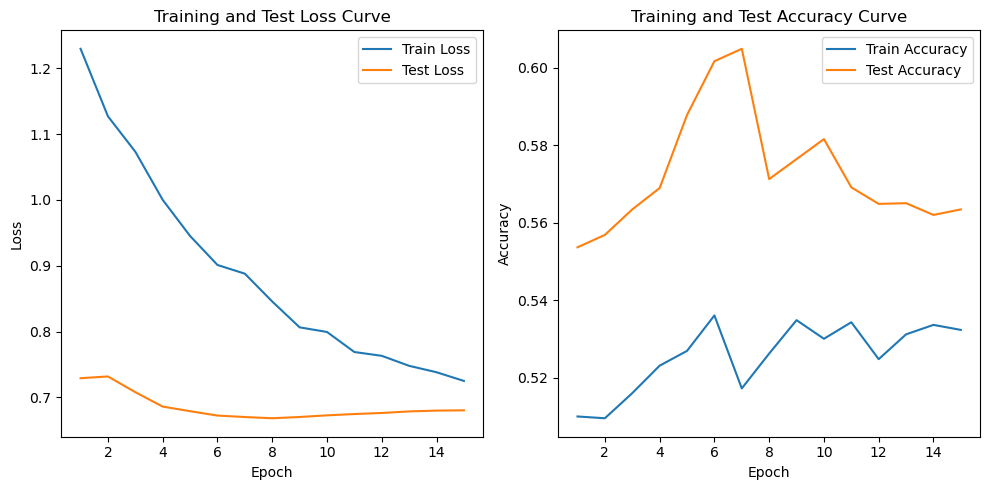

Best accuracy: 0.6048329779673063


In [86]:
model = vpnClassifier(embed_size=20, n_features=23, num_layers=1, heads=5, dropout=0.5)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 15
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for t in range(epochs):
  train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f"Epoch {t+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")

Epoch 1/150, Train Loss: 0.9052, Test Loss: 0.6877, Train Accuracy: 0.5338, Test Accuracy: 0.5300
Epoch 2/150, Train Loss: 0.6815, Test Loss: 0.6717, Train Accuracy: 0.5680, Test Accuracy: 0.5824
Epoch 3/150, Train Loss: 0.6737, Test Loss: 0.6689, Train Accuracy: 0.5868, Test Accuracy: 0.5832
Epoch 4/150, Train Loss: 0.6681, Test Loss: 0.6776, Train Accuracy: 0.5926, Test Accuracy: 0.6047
Epoch 5/150, Train Loss: 0.6688, Test Loss: 0.6764, Train Accuracy: 0.5882, Test Accuracy: 0.6116
Epoch 6/150, Train Loss: 0.6660, Test Loss: 0.6615, Train Accuracy: 0.5974, Test Accuracy: 0.5865
Epoch 7/150, Train Loss: 0.6615, Test Loss: 0.6568, Train Accuracy: 0.5989, Test Accuracy: 0.5899
Epoch 8/150, Train Loss: 0.6622, Test Loss: 0.6622, Train Accuracy: 0.5986, Test Accuracy: 0.6007
Epoch 9/150, Train Loss: 0.6603, Test Loss: 0.6596, Train Accuracy: 0.5995, Test Accuracy: 0.6141
Epoch 10/150, Train Loss: 0.6575, Test Loss: 0.6792, Train Accuracy: 0.6069, Test Accuracy: 0.6114
Epoch 11/150, Train

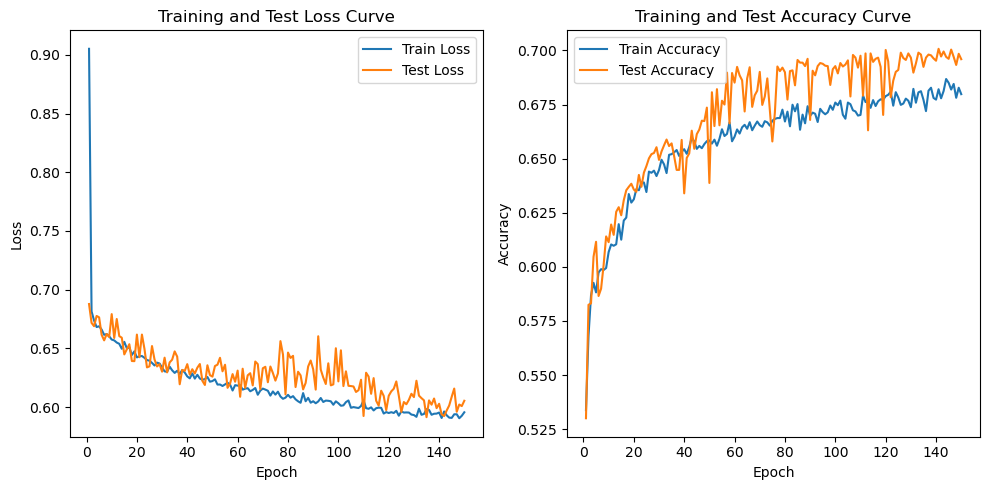

Best accuracy: 0.7007818052594172


In [87]:
model = vpnClassifier(embed_size=60, num_layers=1, heads=15, dropout=0.5)
loss_fn = nn.BCELoss()
optimizer = torch.optim.RMSprop(params=model.parameters(), lr=0.0001, momentum=0.9)

epochs = 150
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for t in range(epochs):
  train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
  test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f"Epoch {t+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best accuracy: {max(test_accuracies)}")